In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import norm

In [2]:
plt.rcParams['svg.fonttype'] = 'none'

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def create_histogram(data, x_title, y_title, h_range, fraction):
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    
    data_size = len(data)
    class_size = int(data_size * fraction)
    x_sens = data[class_size - 1]
    x_resist = data[data_size - class_size]
    
    plt.hist(x=[data[i] for i in range(class_size)], bins=9, rwidth=0.85)
    plt.hist(x=[data[i] for i in range(data_size - class_size, data_size)], bins=9, rwidth=0.85)
    plt.hist(x=[data[i] for i in range(class_size, data_size - class_size)], bins=2, color='darkgrey', rwidth=0.85)
    
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.axvline(x_sens, linewidth=2, color='black')
    plt.axvline(x_resist, linewidth=2, color='black')
    
    ax.grid(False)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [4]:
def create_line_curve(X, Y, x_title, y_title, x_lim, y_lim):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.plot(X, Y)
    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [36]:
def create_kaplan_meier(T1, T2, E1, E2, entity):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    kmf_d = KaplanMeierFitter()
    
    kmf_d = kmf_d.fit(T1, event_observed=E1, label='Sensitive (n = ' + str(len(T1)) + ')')
    kmf_d.plot(ci_show=False, ax=ax)
    print('Median Survival (Sensitive): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T2, event_observed=E2, label='Resistant (n = ' + str(len(T2)) + ')')
    kmf_d.plot(ci_show=False, ax=ax)
    print('Median Survival (Resistant): {:.1f}'.format(kmf_d.median_survival_time_))
    
    ax.set_xlim(0, 60)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Overall Survival Months')
    ax.set_ylabel('Surviving Fractions')
    plt.title(entity + " Survival plot")
    plt.show()
    
    return fig

In [8]:
def categorize_samples_3class(genie_drug_data, drug, fraction):

    data_size = len(genie_drug_data)
    category_size = int(data_size * fraction)
    genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)

    survival_list = []
    for i in range(category_size):
        survival = genie_drug_data.at[i, 'Overall_Survival_Months']
        event = 1
        if survival >= 60:
            event = 0
        temp_df = pd.DataFrame([[survival, 1, event]], columns=['Overall_Survival_Months', 'response', 'event'])
        survival_list.append(temp_df)
    
    for i in range(data_size - category_size, data_size):
        survival = genie_drug_data.at[i, 'Overall_Survival_Months']
        event = 1
        if survival >= 60:
            event = 0
        temp_df = pd.DataFrame([[survival, 0, event]], columns=['Overall_Survival_Months', 'response', 'event'])
        survival_list.append(temp_df)

    survival_df = pd.concat(survival_list, axis=0, ignore_index=True)
    return survival_df

In [20]:
def get_best_param_3class(genie_drug_data, drug):
    
    df_list = []
    best_pval = 1.0
    best_f = 0
    best_df = 0
    
    f_min = 0.1
    f_max = 0.51

    f = f_min
    while f < f_max:
        
        survival_df = categorize_samples_3class(genie_drug_data, drug, f)
        T1 = list(survival_df[survival_df['response'] == 1]['Overall_Survival_Months'])
        T2 = list(survival_df[survival_df['response'] == 0]['Overall_Survival_Months'])
        E1 = list(survival_df[survival_df['response'] == 1]['event'])
        E2 = list(survival_df[survival_df['response'] == 0]['event'])

        pval = logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value
        if best_pval > pval:
            best_pval = pval
            best_f = f
            best_df = survival_df
        df = pd.DataFrame([[f, pval]], columns=['Cut_off', 'P_Value'])
        df_list.append(df)
        
        f += 0.01

    print('Most optimal cut-off: {:.4f}'.format(best_f))
    pval_df = pd.concat(df_list, axis=0, ignore_index=True)
    create_line_curve(pval_df['Cut_off'], pval_df['P_Value'], 'Cut_off', 'P_Value', (f_min, f_max), (0.0, 0.5))
    
    return best_df

In [39]:
def genie_analysis_folds(test_data, genie_drug_data, d, h_range, fold_size=5):
    
    genie_drug_data[d] = 0.0

    corr_sum = 0.0
    count = 0
    for k in range(1, fold_size+1):
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + d + '_auc_' + str(k) + '/predict_genie.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, d] = p_auc

        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        survival_df = get_best_param_3class(genie_drug_data, d)
        # create_histogram(genie_drug_data[d], 'AUC', 'Frequency', h_range, 0.30)
        T1 = list(survival_df[survival_df['response'] == 1]['Overall_Survival_Months'])
        T2 = list(survival_df[survival_df['response'] == 0]['Overall_Survival_Months'])
        E1 = list(survival_df[survival_df['response'] == 1]['event'])
        E2 = list(survival_df[survival_df['response'] == 0]['event'])
        print('p-value: {:.4f}'.format(logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value))
        km_fig = create_kaplan_meier(T1, T2, E1, E2, d)
        # km_fig.savefig('../plots/genie_survival_plot_' + str(k) + '.svg')
        
        print('_' * 70)

In [ ]:
def genie_analysis_single_model(test_data, genie_drug_data, d, h_range, best_frac=0.3):
    
    genie_drug_data[d] = 0.0

    corr_sum = 0.0
    count = 0
    
    predict_data = np.loadtxt('../models_2/model_ctg_av_' + d + '_auc/predict_genie.txt')
    pred_df = pd.Series(predict_data, name='pred')
    pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

    for i, row in genie_drug_data.iterrows():
        sampleId = row['Sample_ID']
        p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
        genie_drug_data.at[i, d] = p_auc

    genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
    #survival_df = get_best_param_3class(genie_drug_data, d)
    histogram = create_histogram(genie_drug_data[d], 'AUC', 'Frequency', h_range, best_frac)
    survival_df = categorize_samples_3class(genie_drug_data, drug, best_frac)
    T1 = list(survival_df[survival_df['response'] == 1]['Overall_Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == 0]['Overall_Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == 0]['event'])
    print('p-value:', logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value)
    km_curve = create_kaplan_meier(T1, T2, E1, E2, d)
    print('_' * 70)
    
    # create_rlipp_test_files(genie_drug_data, d, best_frac)
    # divide_predict_data(pred_df, genie_drug_data, d, best_frac)

    return histogram, km_curve

In [11]:
func_map = {}
func_map['Palbociclib'] = 'CDK4_6_Inhibitor_Overall'

smiles_map = {'Palbociclib':"CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C"}

In [12]:
#Common data

genie_data = pd.read_csv('../data/GENIE/brca_akt1_genie_2019_clinical_data.tsv', sep='\t')
genie_data.columns = genie_data.columns.str.replace(' ','_', regex=False)
genie_data.columns = genie_data.columns.str.replace('/','_', regex=False)
genie_data.columns = genie_data.columns.str.replace('(','', regex=False)
genie_data.columns = genie_data.columns.str.replace(')','', regex=False)

all_genie_genes = pd.read_csv('../data/GENIE/GENIE_gene_list.txt', header=None, names=['G'])['G']

all_mutation_data = pd.read_csv('../data/GENIE/sample_matrix_all_genes.txt', sep='\t')
all_mutation_data['sampleId'] = all_mutation_data['studyID:sampleId'].str.split(":", expand=True)[1]
all_mutation_data.drop(columns =['studyID:sampleId'], inplace = True)

Sample size: 126
Most optimal cut-off: 0.5000


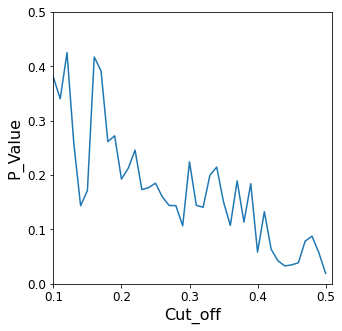

p-value: 0.0188
Median Survival (Sensitive): 40.7
Median Survival (Resistant): 28.1


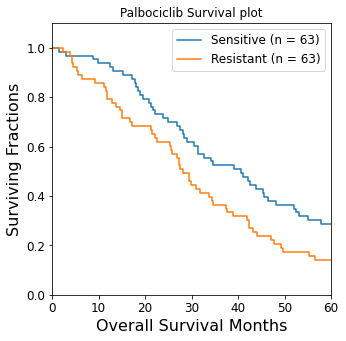

______________________________________________________________________
Most optimal cut-off: 0.3900


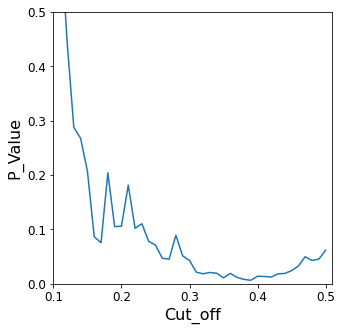

p-value: 0.0061
Median Survival (Sensitive): 43.2
Median Survival (Resistant): 28.1


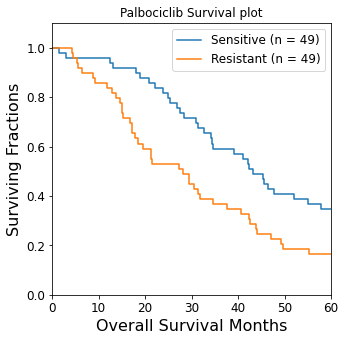

______________________________________________________________________
Most optimal cut-off: 0.4300


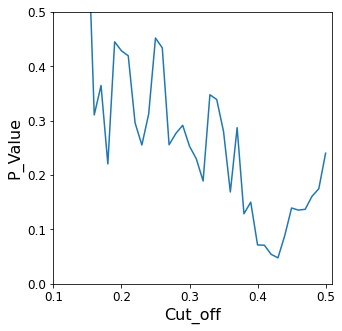

p-value: 0.0474
Median Survival (Sensitive): 41.0
Median Survival (Resistant): 28.1


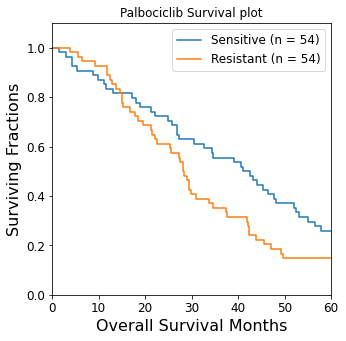

______________________________________________________________________
Most optimal cut-off: 0.5000


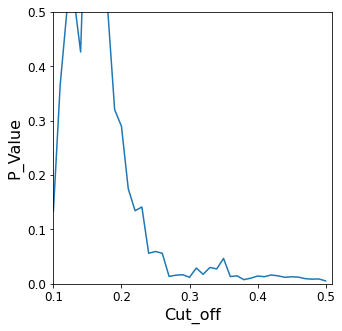

p-value: 0.0050
Median Survival (Sensitive): 42.2
Median Survival (Resistant): 27.3


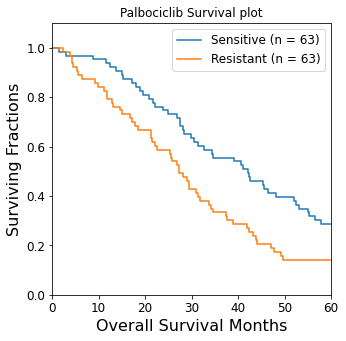

______________________________________________________________________
Most optimal cut-off: 0.4600


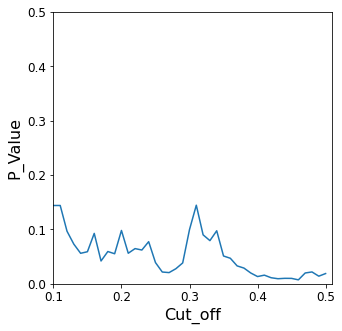

p-value: 0.0069
Median Survival (Sensitive): 41.0
Median Survival (Resistant): 27.3


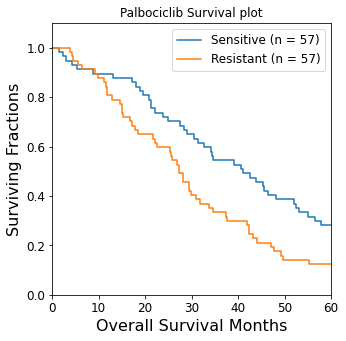

______________________________________________________________________


In [40]:
drug = 'Palbociclib'

test_data = generate_test_data(genie_data, drug)
    
genie_drug_data = copy.deepcopy(genie_data)
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

h_range = (0.60, 0.88)
genie_analysis_folds(test_data, genie_drug_data, drug, h_range)

In [ ]:
drug = 'Palbociclib'

test_data = generate_test_data(genie_data, drug)

genie_drug_data = copy.deepcopy(genie_data)
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

h_range = (0.60, 0.88)
fraction = 0.5
histogram, km_curve = genie_analysis_single_model(test_data, genie_drug_data, drug, h_range, fraction)

In [ ]:
km_curve.savefig('../plots/genie_kmcurve.svg')

In [ ]:
#for d in smiles_map.keys():
#    test_data = generate_test_data(genie_data, smiles_map[d])
#    test_data.to_csv("../data/GENIE/GENIE_test_av_" + d + ".txt", sep='\t', header=False, index=False)